In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

RANDOM_SEED = 42

In [2]:
# mounting drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# importing dataset
filePath = '/content/drive/My Drive/Process Quality Control - PLS project'
fileName = 'process_data.csv'
data = pd.read_csv(os.path.join(filePath, fileName))
data.head()

,solutionA_inletFlowRate,water_inletFlowRate,solutionB_inletFlowRate,componentA_inletConcentration,componentB_inletConcentration,solutionA_inletTemperature,water_inletTemperature,solutionB_inletTemperature,componentA_outletConcentration,componentB_outletConcentration,componentC_outletConcentration,outletTemperature
0,2.488026,7.022645,0.493385,7.415100,12.313350,29.232410,10.161989,29.204568,1.747784,0.414548,0.192728,96.089927
1,2.564250,7.210281,0.521194,7.001721,12.246920,30.321235,9.813532,29.937081,1.649414,0.431103,0.188865,95.193304
2,2.578252,7.356546,0.530302,7.039666,11.964474,29.647262,9.939467,30.877037,1.648039,0.433679,0.172601,88.922935
3,2.438043,6.534329,0.492974,7.097230,12.032390,29.074167,10.126576,30.156679,1.716432,0.403386,0.223285,108.955373
4,2.222003,6.377055,0.496884,7.185610,11.724253,31.573436,10.024570,28.878612,1.637008,0.403802,0.236659,114.179174


In [4]:
# checking data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   solutionA_inletFlowRate         5000 non-null   float64
 1   water_inletFlowRate             5000 non-null   float64
 2   solutionB_inletFlowRate         5000 non-null   float64
 3   componentA_inletConcentration   5000 non-null   float64
 4   componentB_inletConcentration   5000 non-null   float64
 5   solutionA_inletTemperature      5000 non-null   float64
 6   water_inletTemperature          5000 non-null   float64
 7   solutionB_inletTemperature      5000 non-null   float64
 8   componentA_outletConcentration  5000 non-null   float64
 9   componentB_outletConcentration  5000 non-null   float64
 10  componentC_outletConcentration  5000 non-null   float64
 11  outletTemperature               5000 non-null   float64
dtypes: float64(12)
memory usage: 468.9

All data attributes are numeric and there are no missing data.

The dataset have 11 process variables : 7 of them are control variables (input) and the remaining 4 are controlled variables (output).

Input variables:
- component A inlet flow rate
- water inlet flow rate
- component B inlet flow rate
- component A inlet concentration
- component B inlet concentration
- solution A inlet temperature
- water inlet temperature
- solution B inlet temperature

Output variables:
- component A output concentration
- component B output concentration
- component C output concentration
- outlet temperature

## **1. Main Objective**

In this process, there are significant variability in reactor output variables. Its is necessary to train a model that can identify anomalies and to propose the necessary corrections to ensure quality control.
However, there are several output variables that need to be controled, because each one has its own importance. The methodology have to permit such multivariable approach.



### 1.1. Specific Objectives

- to do preliminary data analysis to outliers and errors identification
- to do exploratory data analysis to identify correlations
- to evaluate process using statistical process control approach
- to build a anomaly detection model that allow proper quality control using only input variables
- to validate the proposed model
- to propose an action plan to drive anomalous process back to "quality" region

## **2. Exploratory Data Analysis**


In [8]:
def control_chart(data, var_name, n = 5):

  # this function builds the control charts of mean and ranges por a specific
  # process, using a sampling plan of n point per minute

  to_monitor = pd.DataFrame(data[var_name], columns=[var_name])

  # dictionary of constants for statistical process control calculations
  d2_dict = {2: 1.128, 3: 1.693, 4: 2.059, 5: 2.326, 6: 2.534, 7: 2.704,
            8: 2.847, 9: 2.970, 10: 3.078, 11: 3.173, 12: 3.258, 13: 3.336,
            14: 3.407, 15: 3.472}
  d3_dict = {2: 0.853, 3: 0.888, 4: 0.880, 5: 0.864, 6: 0.848, 7: 0.833,
            8: 0.820, 9: 0.808, 10: 0.797, 11: 0.787, 12: 0.778, 13: 0.770,
            14: 0.763, 15: 0.756}

  # grouping of values
  to_monitor_mean = to_monitor.groupby(to_monitor.index//n).agg({var_name:'mean'})
  to_monitor_max = to_monitor.groupby(to_monitor.index//n).agg({var_name:'max'})
  to_monitor_min = to_monitor.groupby(to_monitor.index//n).agg({var_name:'min'})

  to_monitor_full = pd.concat([to_monitor_mean, to_monitor_max], axis = 1)
  to_monitor_full = pd.concat([to_monitor_full, to_monitor_min], axis = 1)

  to_monitor_full.columns = ['Avg','Max','Min']
  to_monitor_full['Amp'] = to_monitor_full['Max'] - to_monitor_full['Min']

  to_monitor_full.drop(['Max','Min'], axis = 1, inplace = True)

  # statistical control chart - range chart
  d2 = d2_dict[n]
  d3 = d3_dict[n]
  R_bar = to_monitor_full['Amp'].mean()
  R_sigma = R_bar*(d3/d2)
  LSC_R = R_bar + 3*R_sigma
  LIC_R = R_bar - 3*R_sigma

  # statistical process control - average chart
  A2 = (3*R_bar)/(d2*np.sqrt(n))
  X_bar = to_monitor_full['Avg'].mean()
  LSC_X = X_bar + (A2*R_bar)
  LIC_X = X_bar - (A2*R_bar)

  plt.figure(figsize=(13,15))
  plt.subplot(2,1,1)
  plt.plot(to_monitor_full['Amp'], 'k.-')
  plt.axhline(y = LSC_R, color = 'r', linestyle = '--')
  plt.axhline(y = LIC_R, color = 'r', linestyle = '--')
  plt.axhline(y = R_bar, color = 'r', linestyle = '--')
  plt.ylabel(var_name, fontsize = 16)
  plt.xlabel('Samples', fontsize = 16)
  plt.title('Control Chart - Ranges - ' + var_name, fontsize = 20)
  plt.grid()

  plt.subplot(2,1,2)
  plt.plot(to_monitor_full['Avg'], 'k.-')
  plt.axhline(y = LSC_X, color = 'r', linestyle = '--')
  plt.axhline(y = LIC_X, color = 'r', linestyle = '--')
  plt.axhline(y = X_bar, color = 'r', linestyle = '--')
  plt.ylabel(var_name, fontsize = 16)
  plt.xlabel('Samples', fontsize = 16)
  plt.title('Control Charts - Averages' + var_name, fontsize = 20)
  plt.grid()

  plt.show()

  # return useful values
  results = {'LIC_R': LIC_R, 'R_bar': R_bar,'LSC_R': LSC_R, 
             'LIC_X': LIC_X, 'X_bar': X_bar, 'LSC_X': LSC_X}

  return results

In [9]:
# distribution exploratory analysis
def hist_boxplot(data, var_name):
  # this function plots histograms and boxplots for the selected variable
  to_monitor = pd.DataFrame(data[var_name], columns=[var_name])

  # vertical lines parameters calculation
  avg = to_monitor[var_name].mean()
  std = to_monitor[var_name].std()

  x1_vline = avg - 3*std
  x2_vline = avg + 3*std

  # histogram and boxplot construction
  fig = plt.figure(figsize=(20,10))
  ax1 = fig.add_subplot(1,2,1)
  sns.histplot(to_monitor[var_name], stat = 'density', kde = True, element = 'step', alpha = 0.7)
  ax1.axvline(x = x1_vline, color = 'r', linestyle = '--')
  ax1.axvline(x = x2_vline, color = 'r', linestyle = '--')
  ax1.set_ylabel('Density', fontsize = 16)
  ax1.set_xlabel(var_name, fontsize = 16)
  ax1.set_title('Histogram - ' + var_name + '\nVertical Lines show +- 3 Std. Deviations', fontsize = 20)
  
  ax2 = fig.add_subplot(1,2,2)
  sns.boxplot(x = to_monitor[var_name], orient = 'h', color = 'g')
  ax2.axvline(x = x1_vline, color = 'r', linestyle = '--')
  ax2.axvline(x = x2_vline, color = 'r', linestyle = '--')
  ax2.set_xlabel(var_name, fontsize = 16)
  ax2.set_title('Boxplot - ' + var_name + '\nVertical Lines show +- 3 Std. Deviations', fontsize = 20)
  
  plt.suptitle('Variability and Distribution Analysis - ' + var_name, size = 22)

In [7]:
# checking number of missing data
data.isna().sum()

solutionA_inletFlowRate           0
water_inletFlowRate               0
solutionB_inletFlowRate           0
componentA_inletConcentration     0
componentB_inletConcentration     0
solutionA_inletTemperature        0
water_inletTemperature            0
solutionB_inletTemperature        0
componentA_outletConcentration    0
componentB_outletConcentration    0
componentC_outletConcentration    0
outletTemperature                 0
dtype: int64

There are no missing data. All the columns and rows are filled with valid values. Let's check the dataset for the presence of outliers values in each variable.

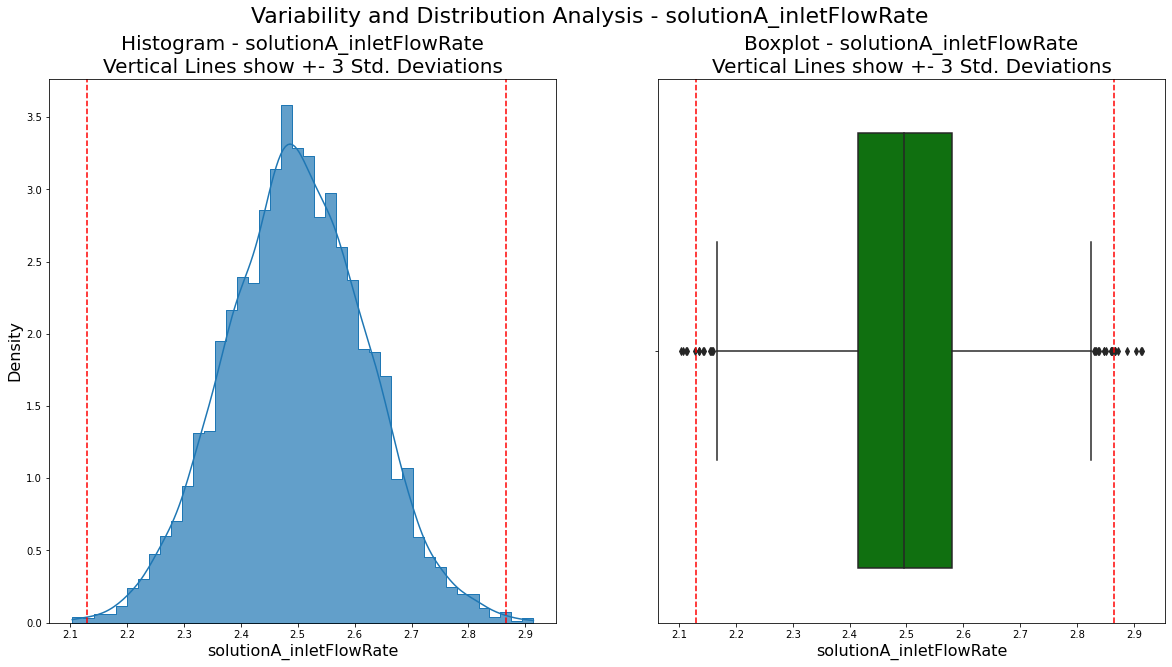

In [10]:
var_name = data.columns[0]
hist_boxplot(data, var_name)

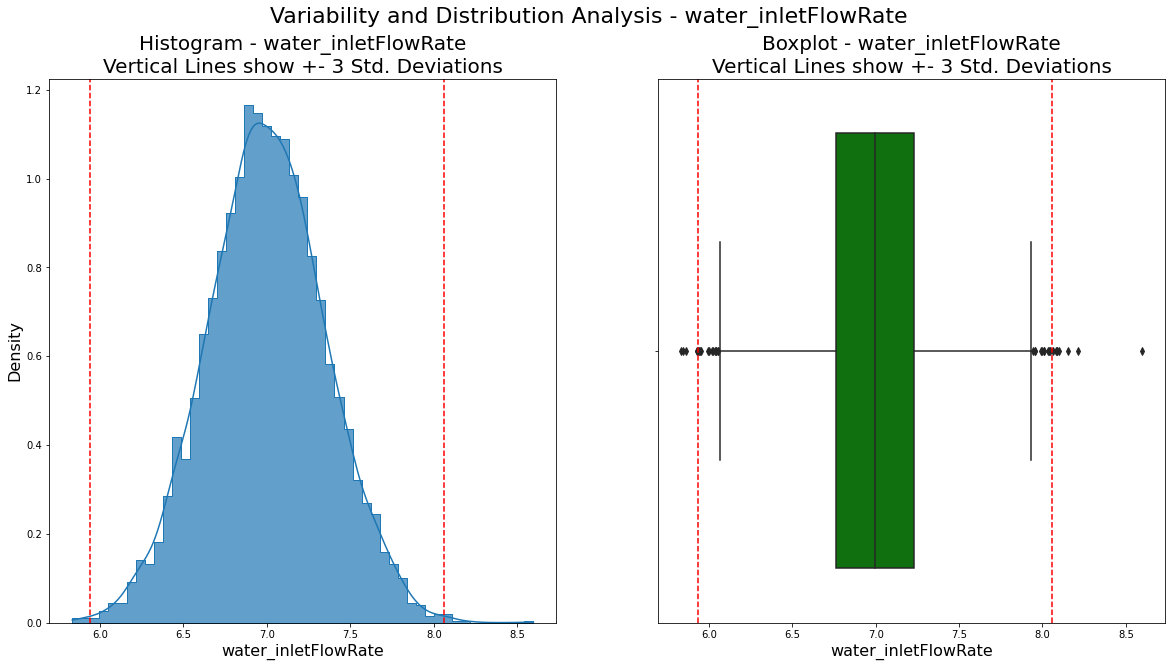

In [11]:
var_name = data.columns[1]
hist_boxplot(data, var_name)

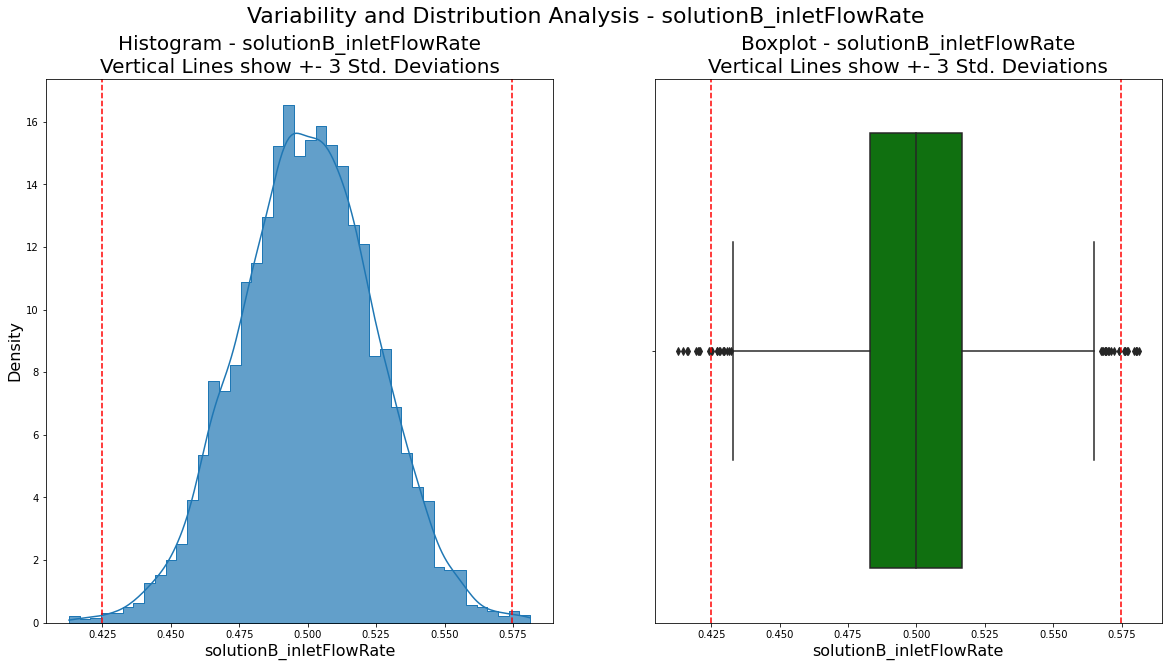

In [12]:
var_name = data.columns[2]
hist_boxplot(data, var_name)

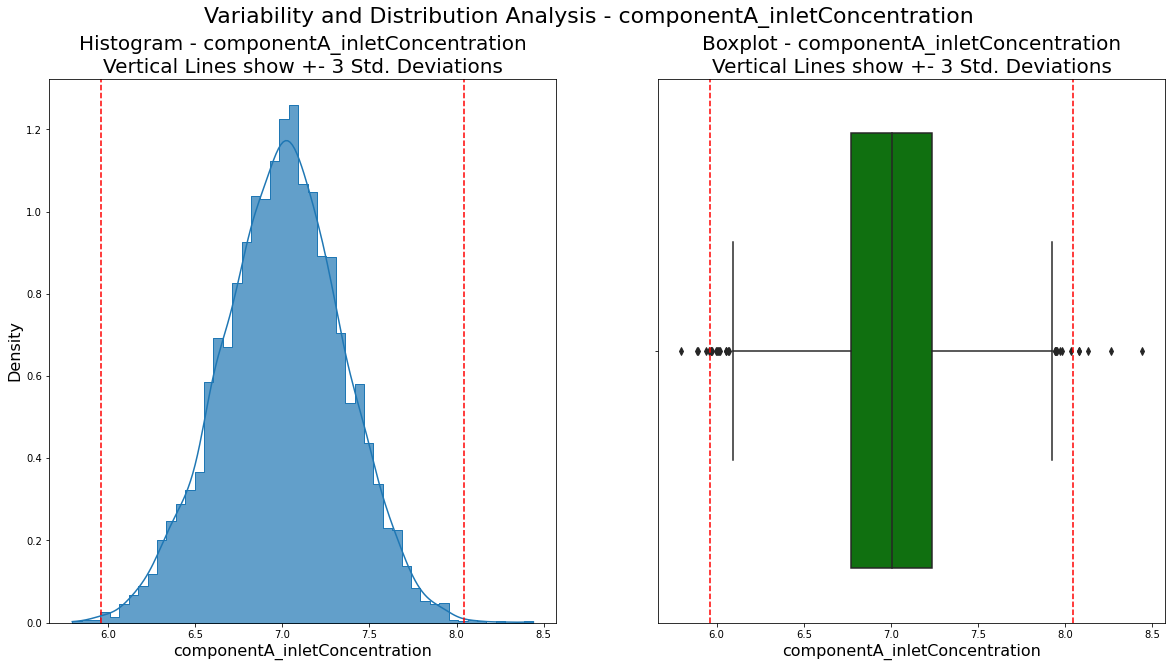

In [13]:
var_name = data.columns[3]
hist_boxplot(data, var_name)

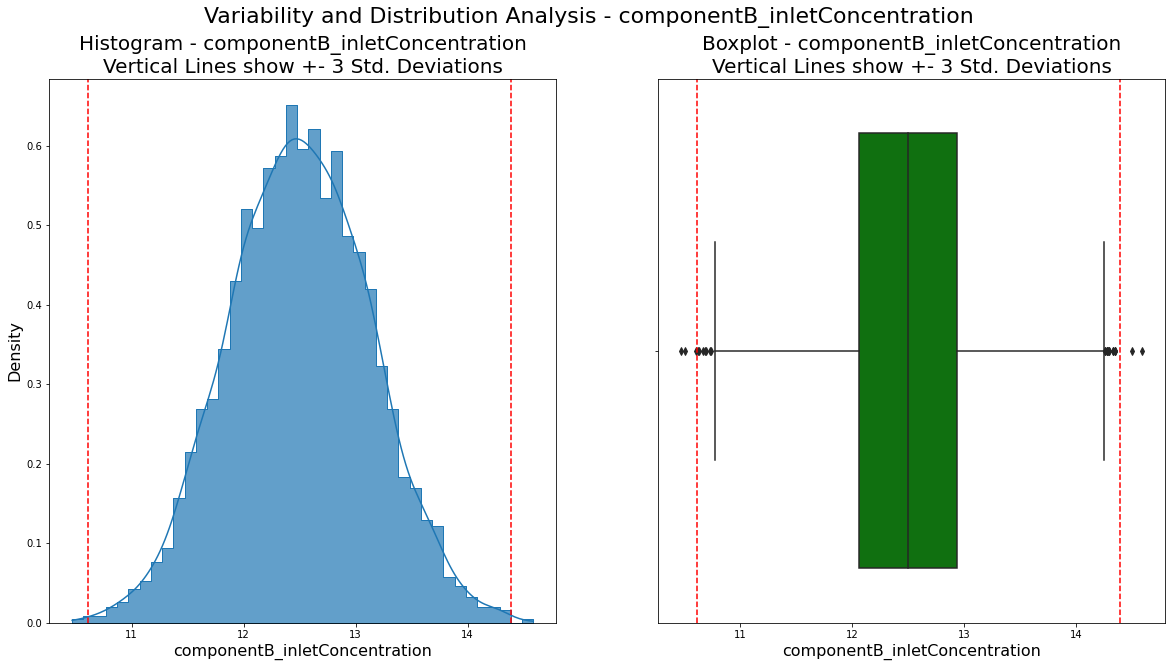

In [14]:
var_name = data.columns[4]
hist_boxplot(data, var_name)

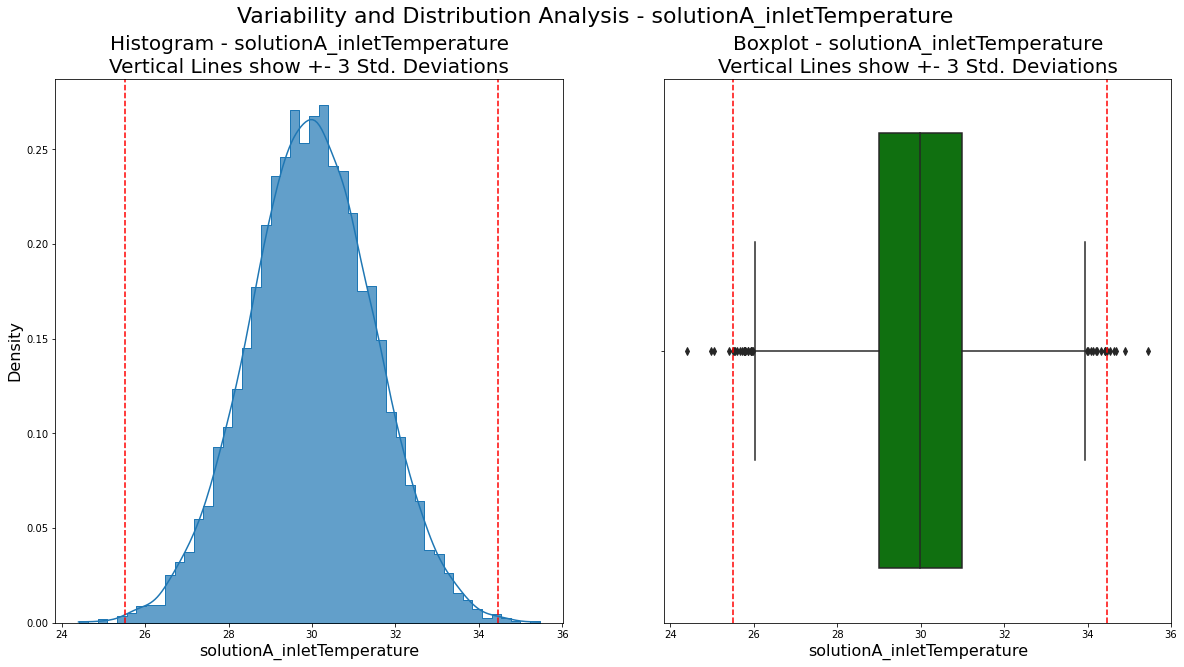

In [15]:
var_name = data.columns[5]
hist_boxplot(data, var_name)

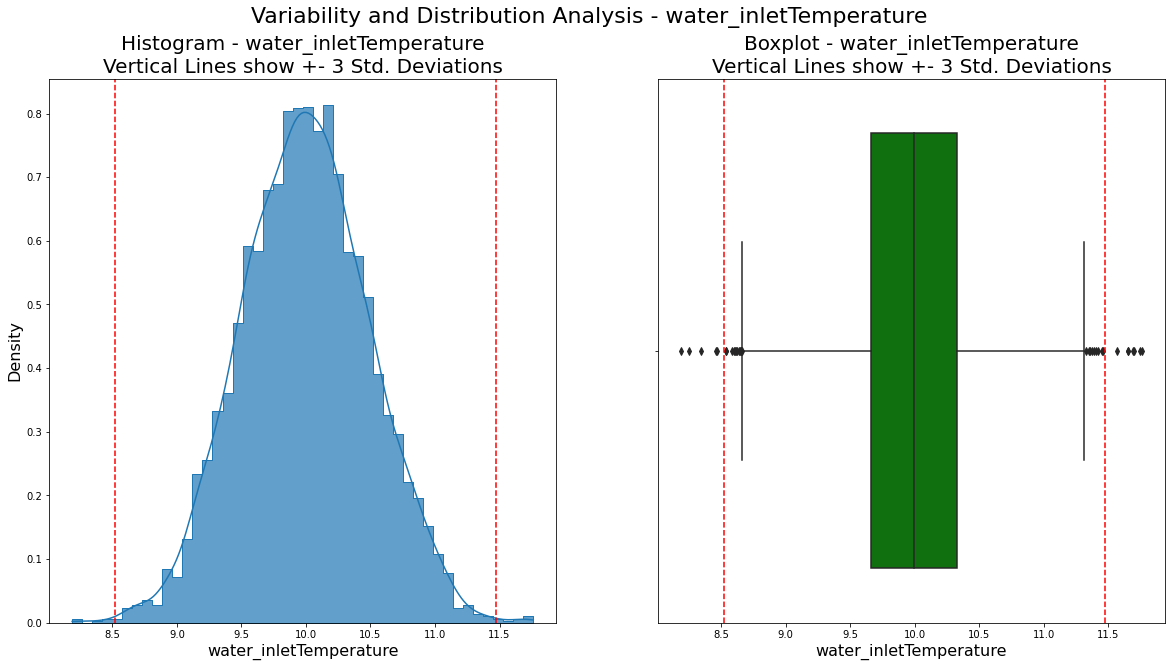

In [16]:
var_name = data.columns[6]
hist_boxplot(data, var_name)

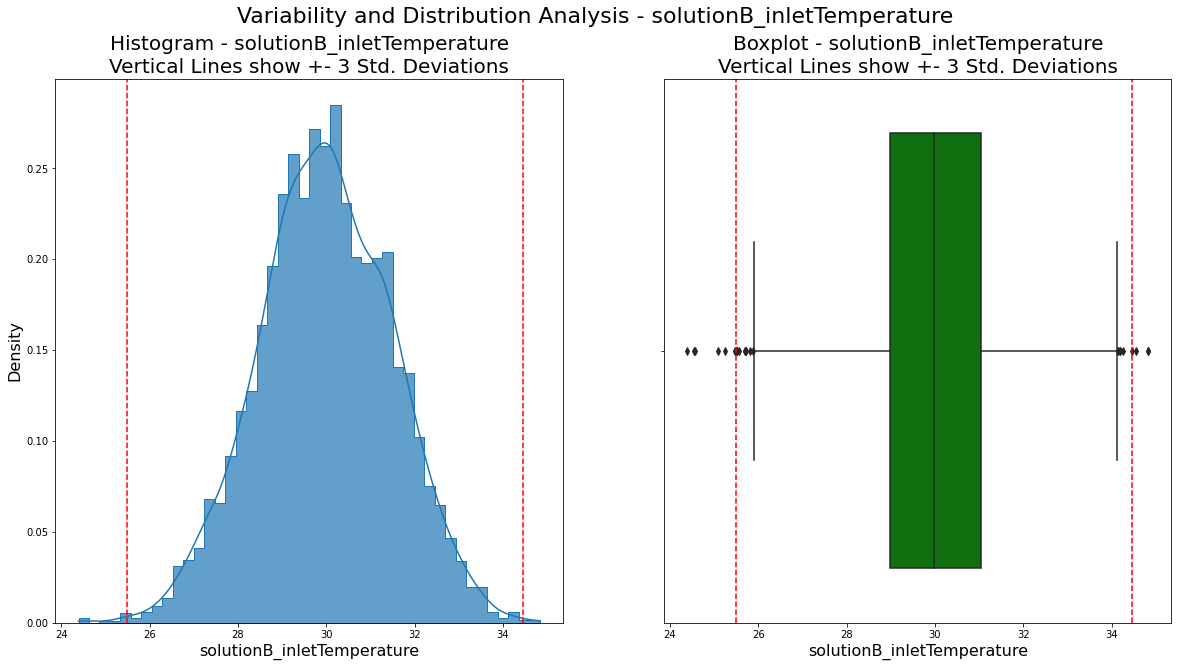

In [17]:
var_name = data.columns[7]
hist_boxplot(data, var_name)

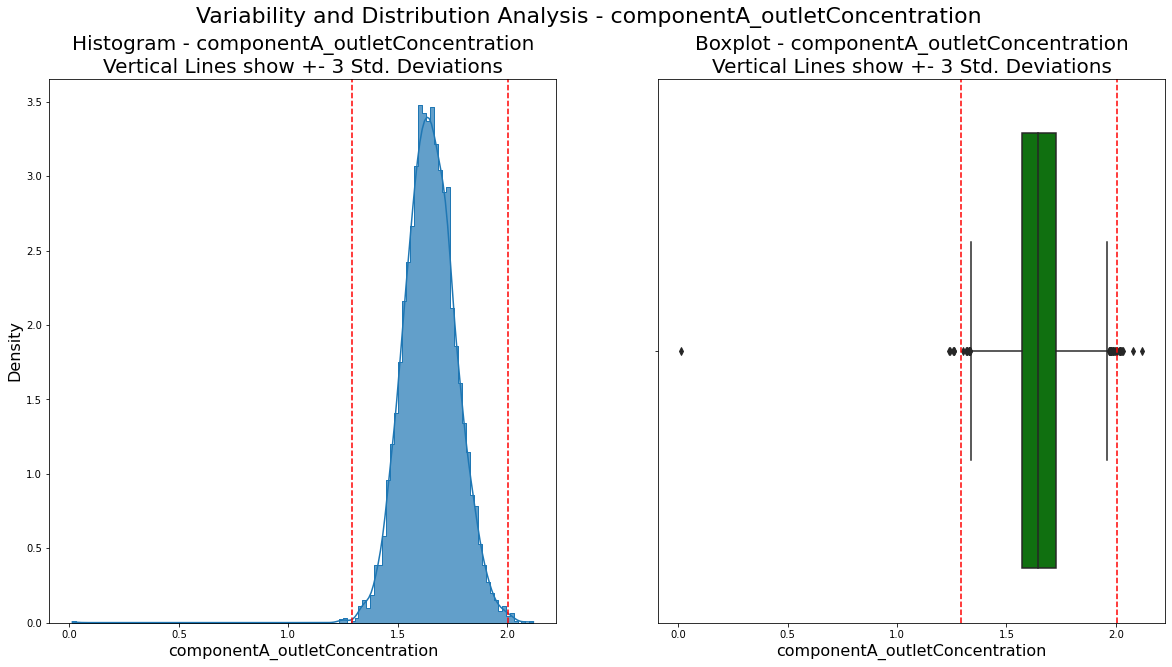

In [18]:
var_name = data.columns[8]
hist_boxplot(data, var_name)

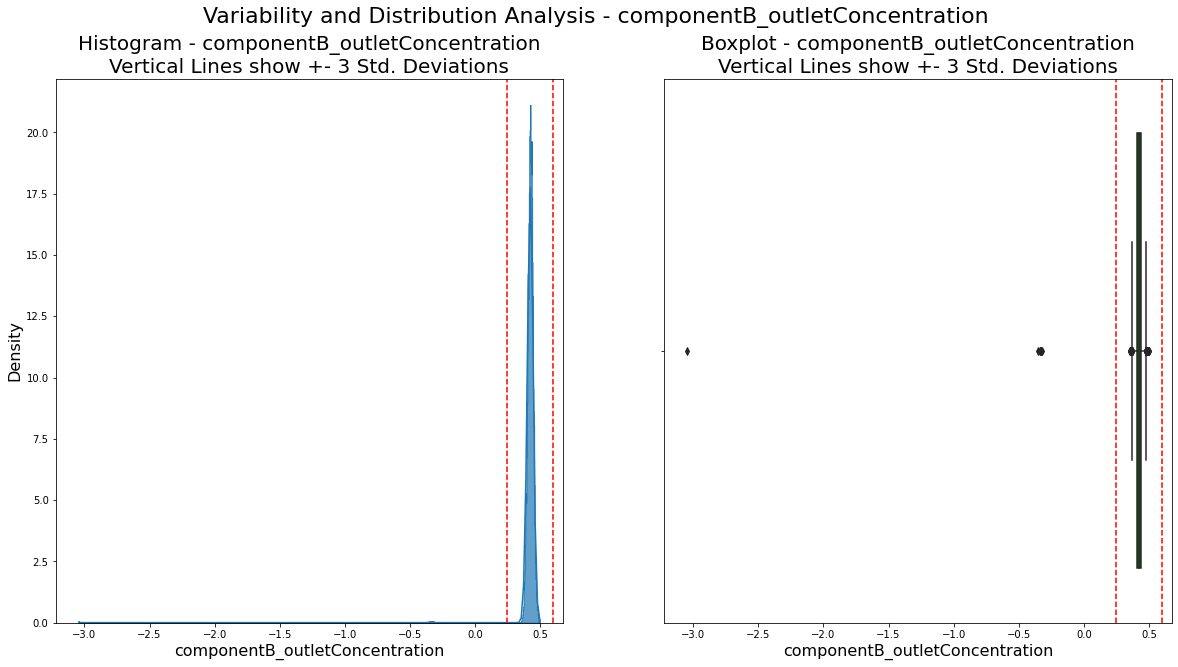

In [19]:
var_name = data.columns[9]
hist_boxplot(data, var_name)

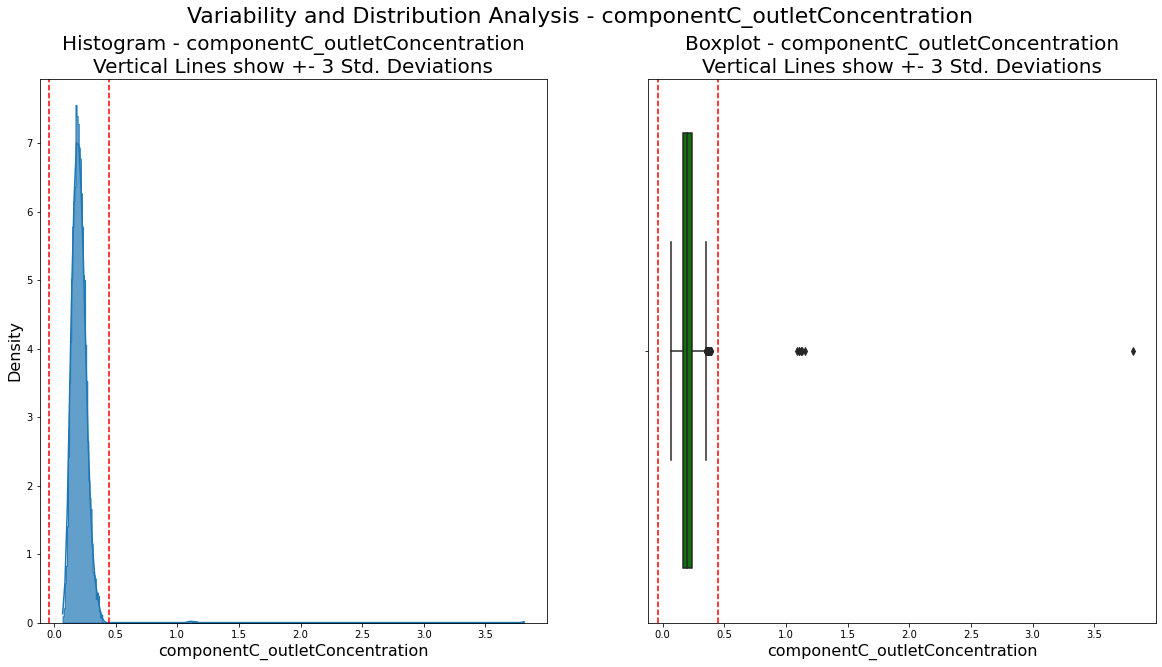

In [20]:
var_name = data.columns[10]
hist_boxplot(data, var_name)

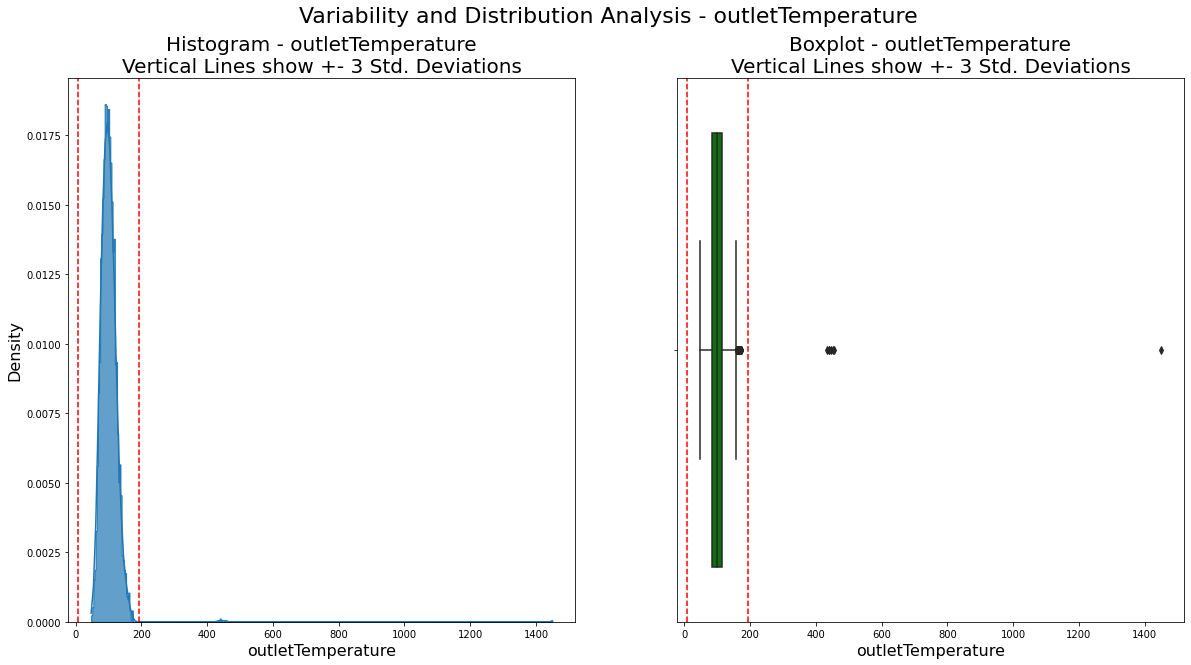

In [21]:
var_name = data.columns[11]
hist_boxplot(data, var_name)

The distribution analysis showed that all variables have outliers values. Some of the variables showed outlier values that do not reflect usual process conditions, promoting a distribution distortion.

It's necessary to clean the data. For this study study, the team decided to get rid of outlier values, because they represent measure errors.

In [24]:
def data_treatment(data, var_name):

  # this function automates data outlier cleaning

  # parameters for elimination 
  avg = data[var_name].mean()
  sd = data[var_name].std()

  # upper and lower limits
  sup = avg + 3*sd
  inf = avg - 3*sd

  # original number of lines
  n_before = data.shape[0]

  # data cleaning 
  data = data.loc[(data[var_name] >= inf) & (data[var_name] <= sup)]

  # final number of lines
  n_after = data.shape[0]

  print('Original Dataset: %d linhas'%n_before)
  print('Cleaned Dataset: %d linhas'%n_after)
  print('Reduction: %.2f %%'%((n_before-n_after)*100/n_before))

  return data

Original Dataset: 5000 linhas
Cleaned Dataset: 4988 linhas
Reduction: 0.24 %


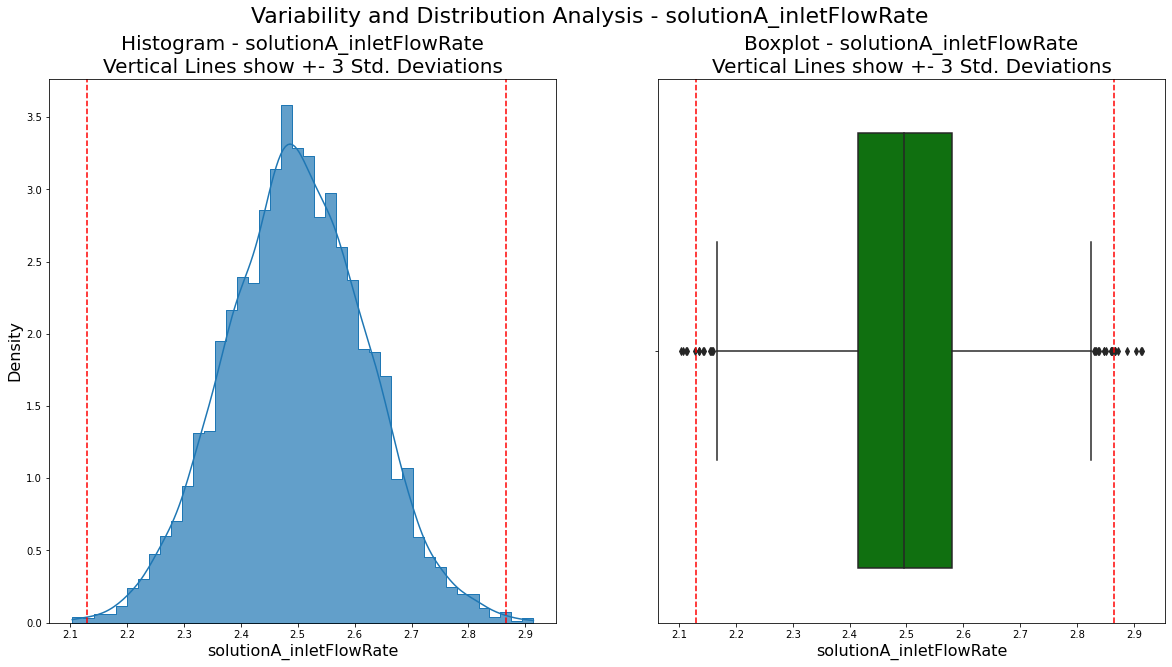

In [25]:
var_name = data.columns[0]
data_t = data_treatment(data, var_name)
hist_boxplot(data, var_name)

In [26]:
#once tested, the function is applied to all other columns of the dataset
columns_list = data.columns

for column in columns_list:
  data_t = data_treatment(data_t, column)

Original Dataset: 4988 linhas
Cleaned Dataset: 4988 linhas
Reduction: 0.00 %
Original Dataset: 4988 linhas
Cleaned Dataset: 4974 linhas
Reduction: 0.28 %
Original Dataset: 4974 linhas
Cleaned Dataset: 4955 linhas
Reduction: 0.38 %
Original Dataset: 4955 linhas
Cleaned Dataset: 4945 linhas
Reduction: 0.20 %
Original Dataset: 4945 linhas
Cleaned Dataset: 4940 linhas
Reduction: 0.10 %
Original Dataset: 4940 linhas
Cleaned Dataset: 4929 linhas
Reduction: 0.22 %
Original Dataset: 4929 linhas
Cleaned Dataset: 4917 linhas
Reduction: 0.24 %
Original Dataset: 4917 linhas
Cleaned Dataset: 4906 linhas
Reduction: 0.22 %
Original Dataset: 4906 linhas
Cleaned Dataset: 4893 linhas
Reduction: 0.26 %
Original Dataset: 4893 linhas
Cleaned Dataset: 4889 linhas
Reduction: 0.08 %
Original Dataset: 4889 linhas
Cleaned Dataset: 4870 linhas
Reduction: 0.39 %
Original Dataset: 4870 linhas
Cleaned Dataset: 4866 linhas
Reduction: 0.08 %


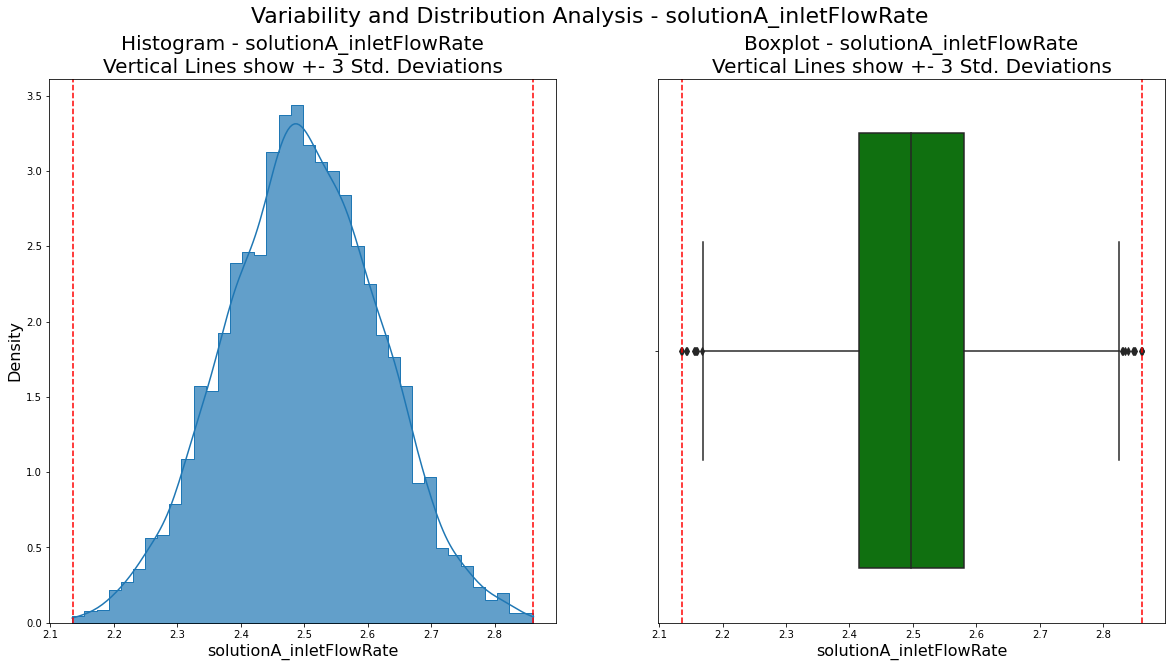

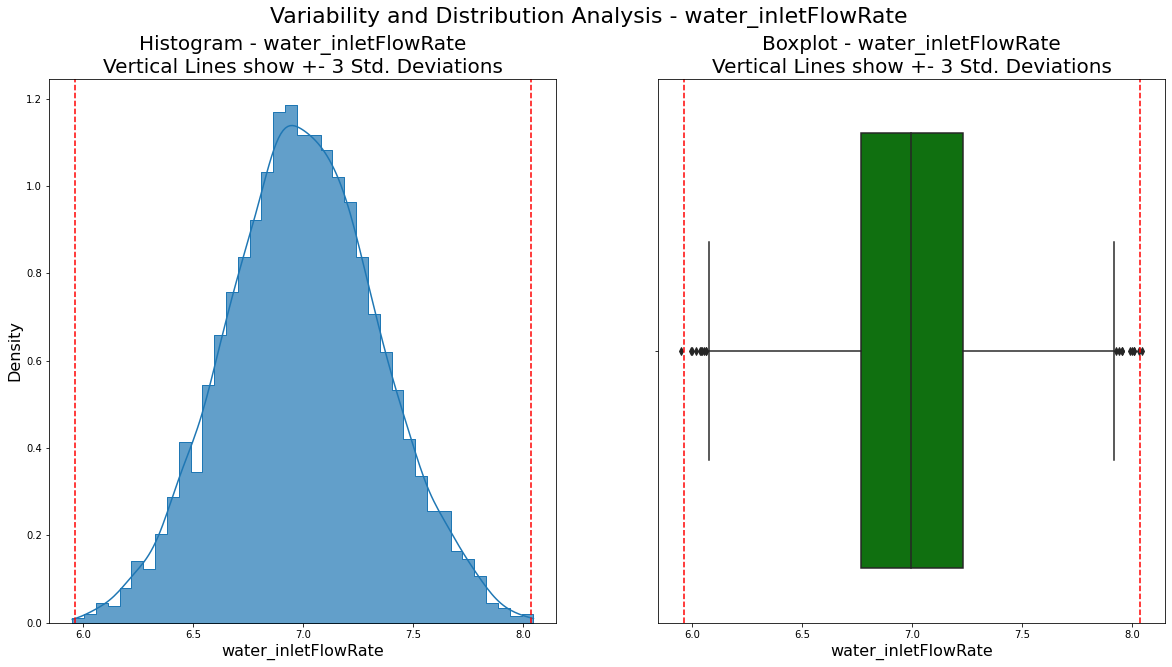

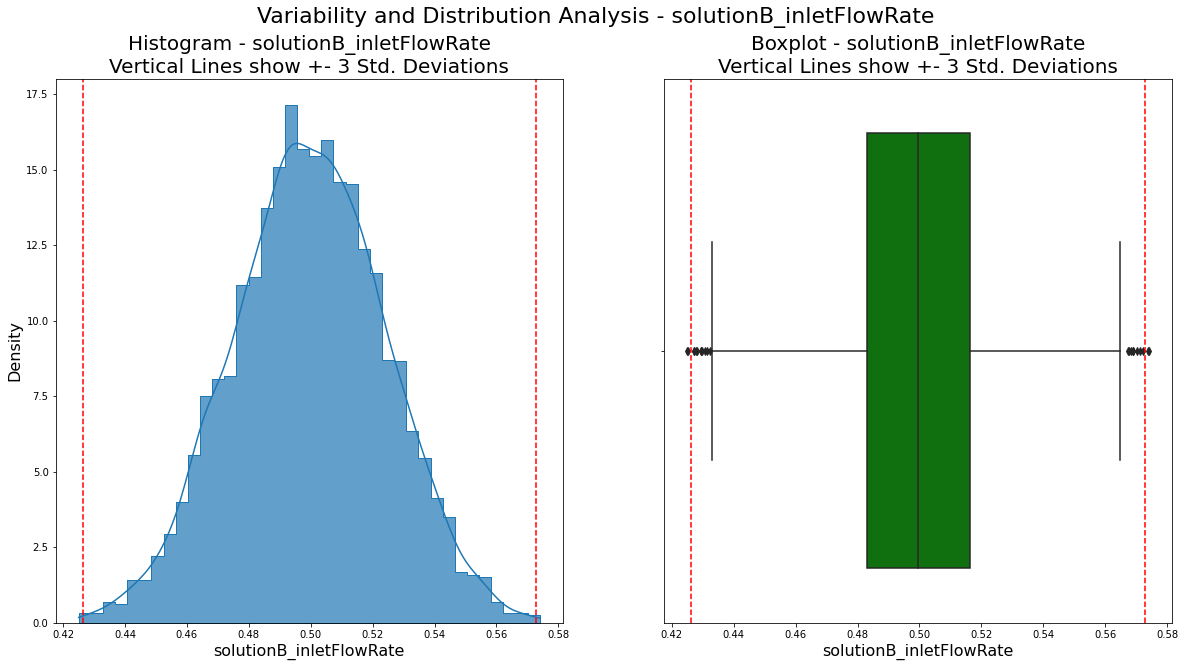

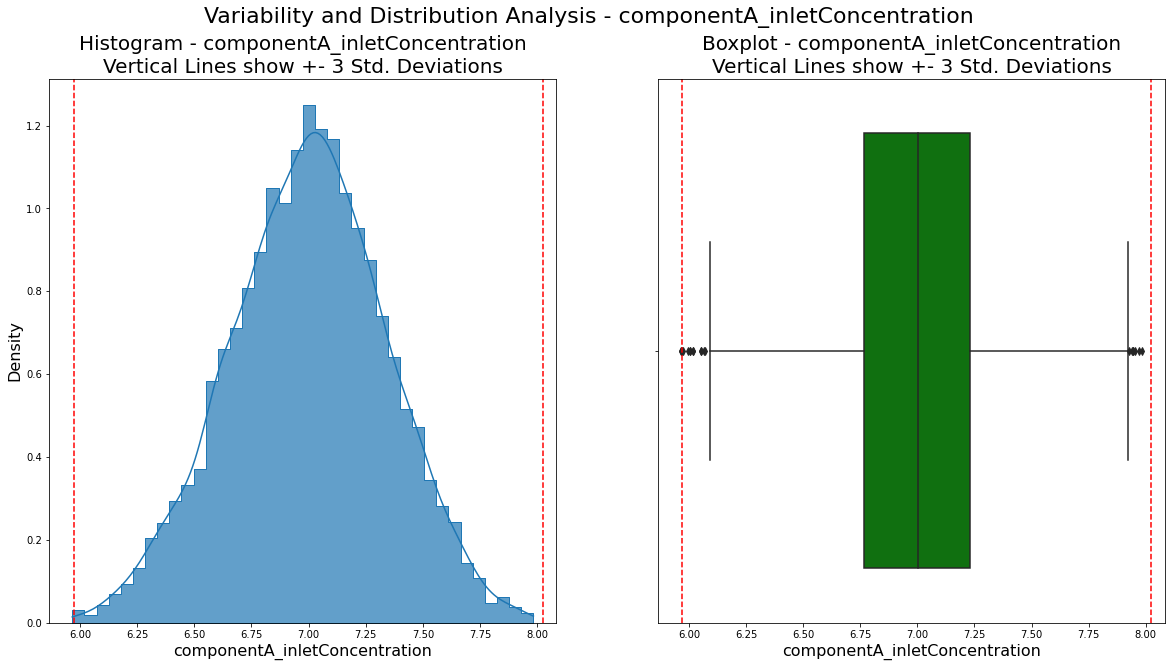

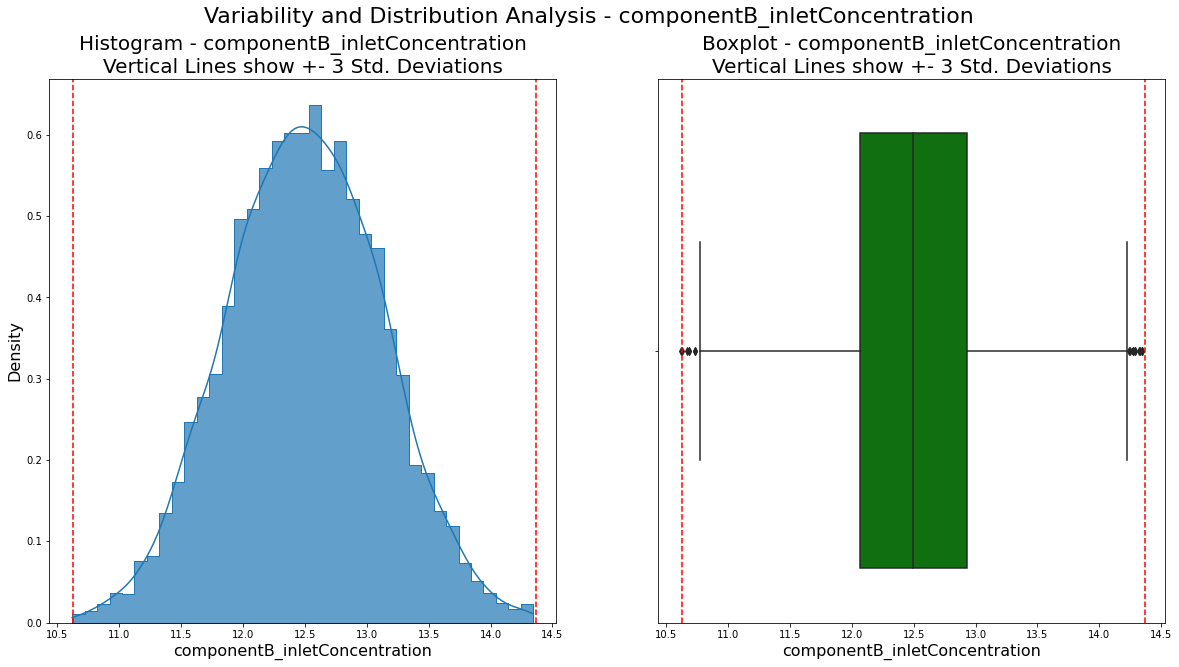

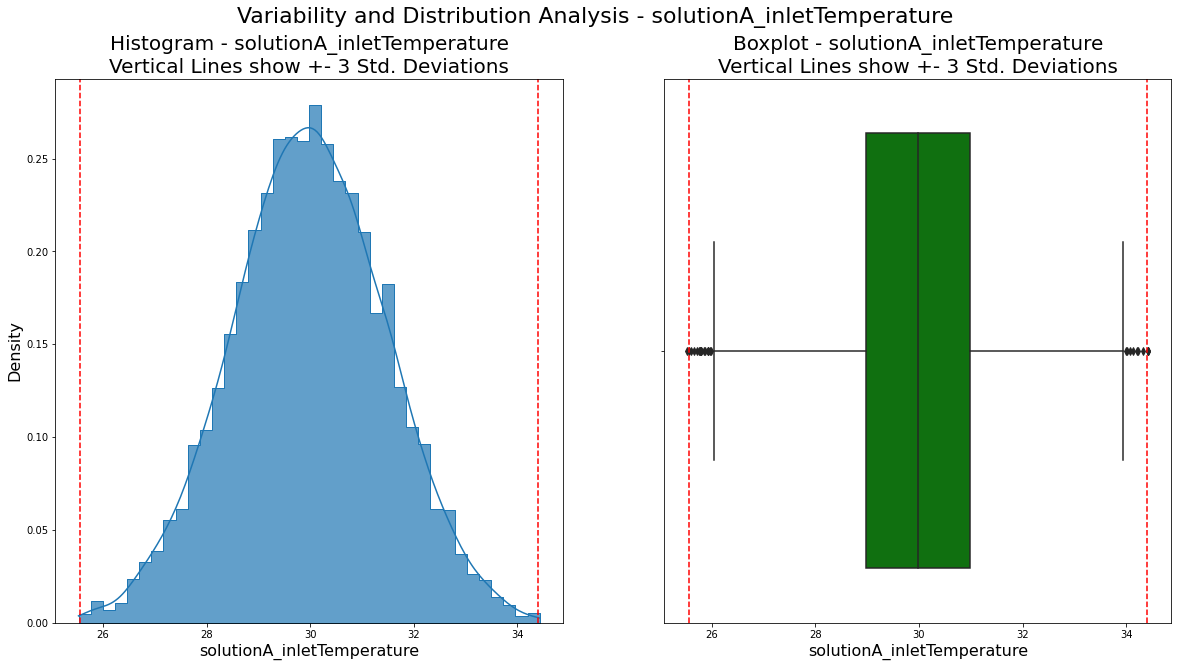

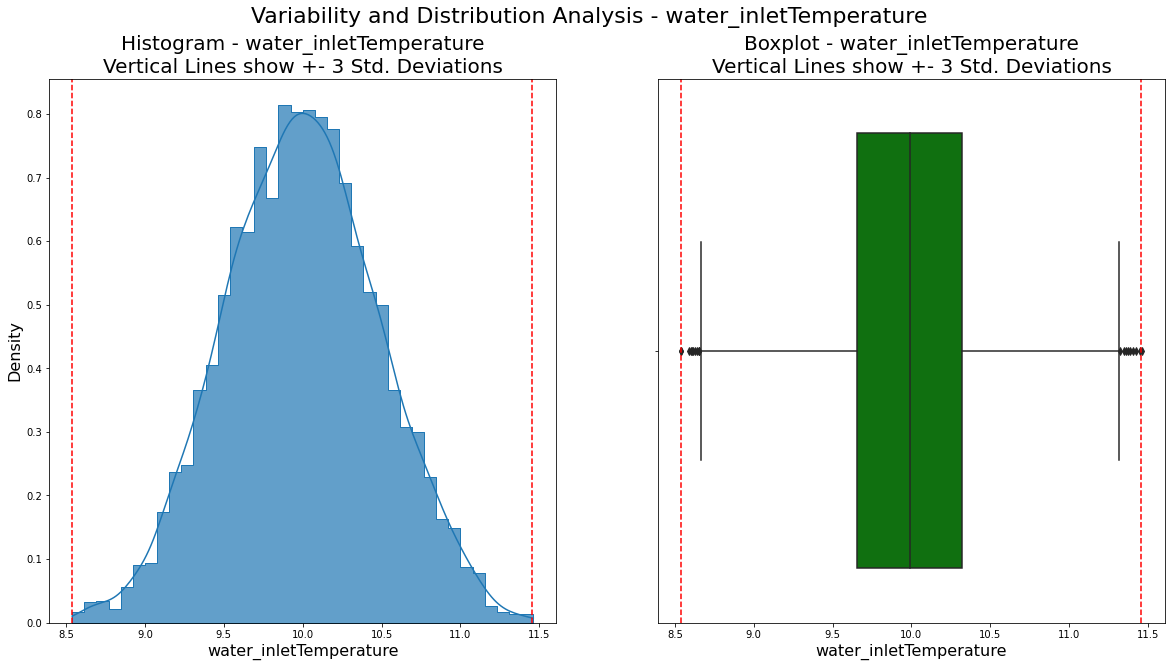

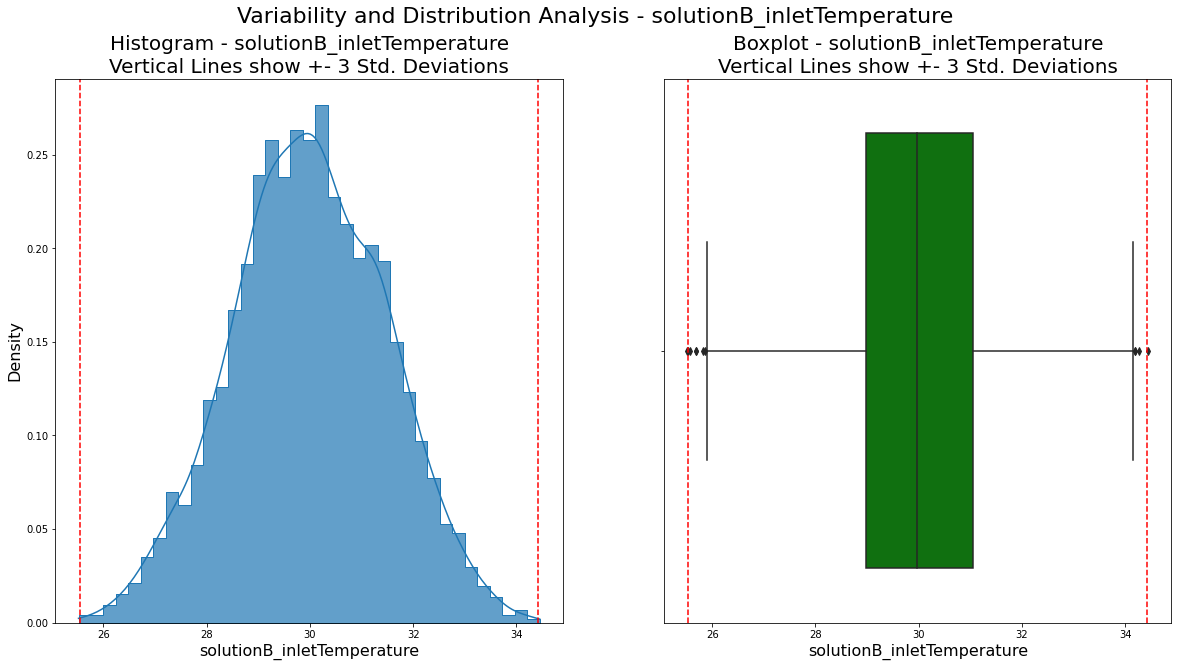

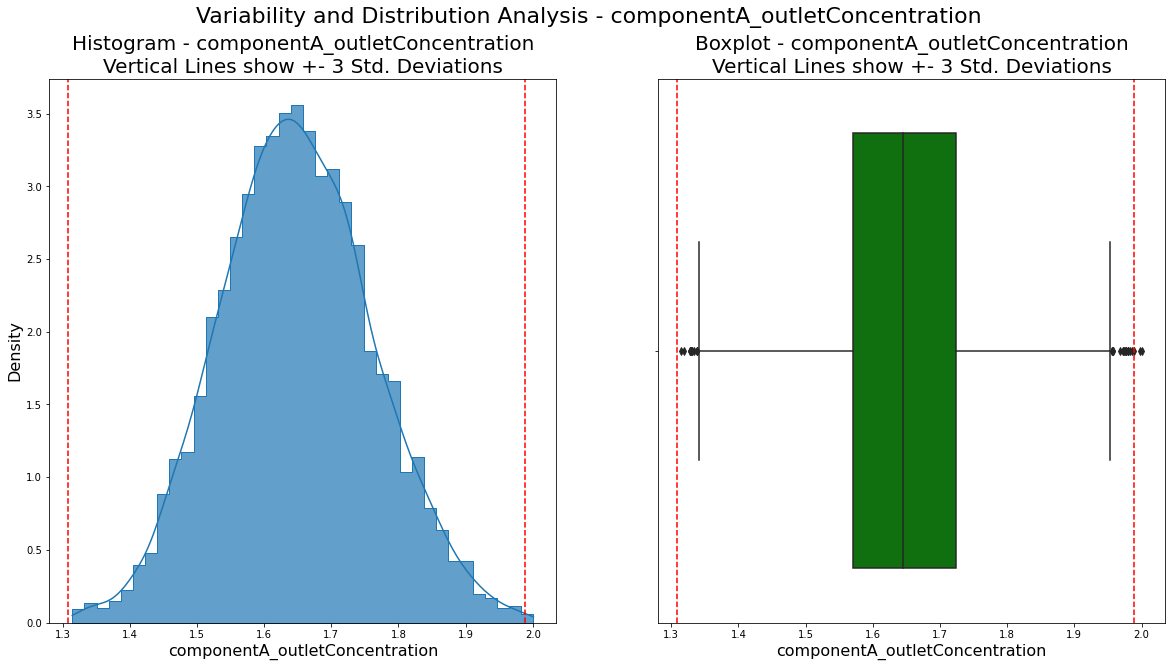

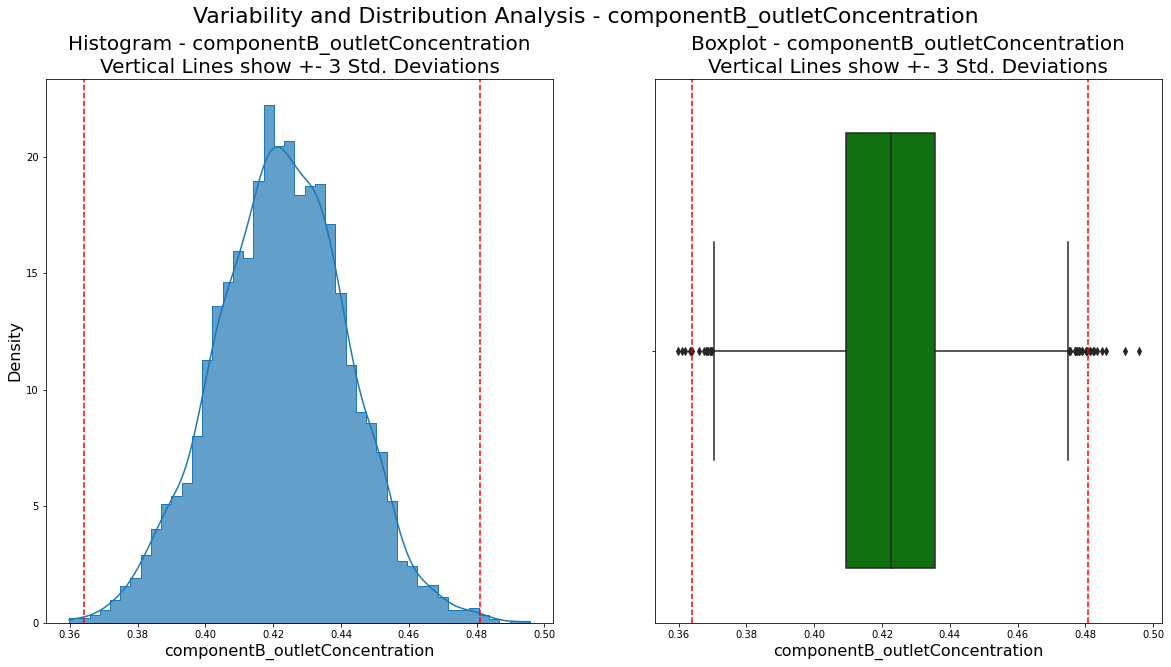

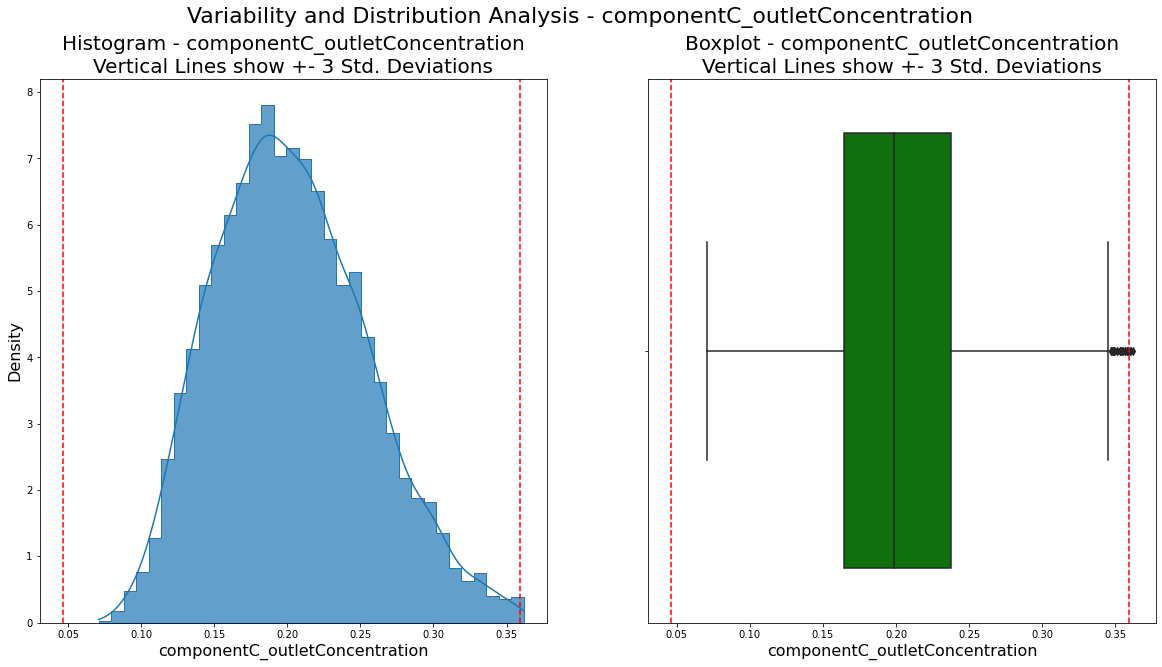

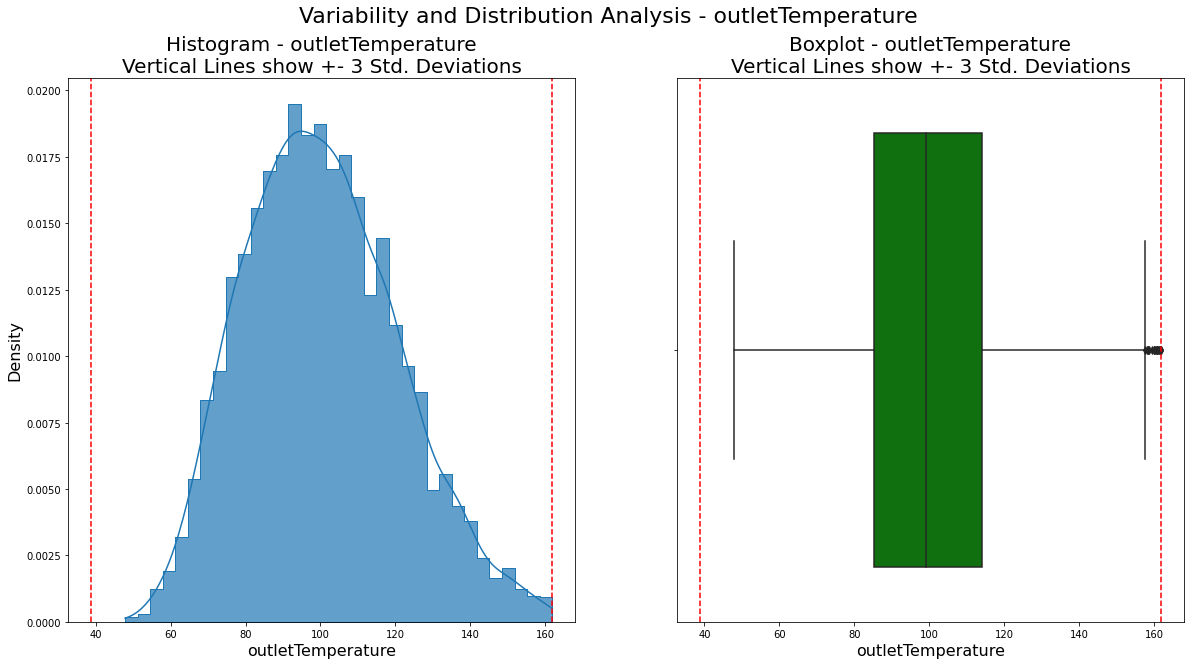

In [27]:
# checking the modifications' effect
for column in columns_list:
  hist_boxplot(data_t, column)

In [28]:
# total reduction of dataset
print('Original Dataset: %d linhas'%data.shape[0])
print('Cleaned Dataset: %d linhas'%data_t.shape[0])
print('Total Reduction: %.2f%%'%((data.shape[0]-data_t.shape[0])*100/data.shape[0]))

Original Dataset: 5000 linhas
Cleaned Dataset: 4866 linhas
Total Reduction: 2.68%


The cleaning of data produced a more symmetric dataset, since all variables distributions present a bell shaped behavior

Next step is to understand the correlation between process variables.

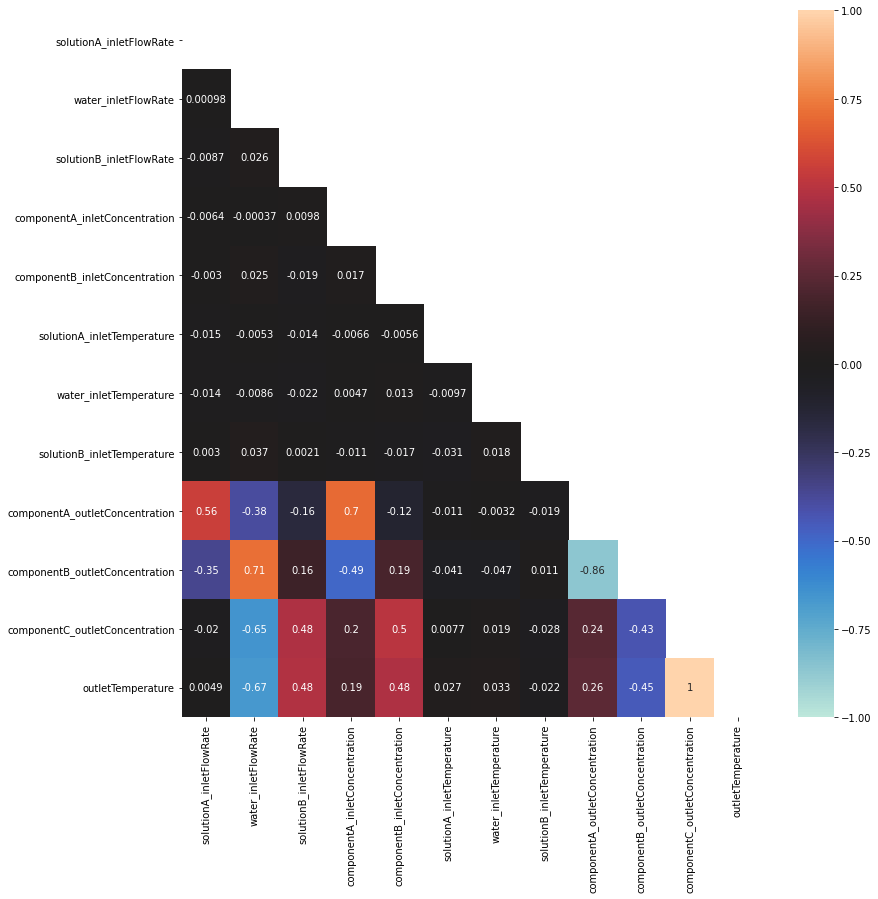

In [29]:
# correlation matrix calculation
corr = data_t.corr()

# heatmap correlation mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# plotting correlation heatmap
plt.figure(figsize = (13,13))
sns.heatmap(corr, mask=mask, vmax=1, center=0, vmin = -1, annot = True)

The correlation matrix shows that the input variables are statistically independent from each other, since the correlation coefficients are next to zero.

However, there are significant correlations between input variables and output variables, which was expected because of the physico-chemical principia that drive chemical processes.

It is also necessary to understang how each variable correlates itself along with its pairs, using scatterplots. A correlation threshold should be applied to limit the analysis to the most promising correlations.


### **2.1. Component A Output Concentration** 

In [32]:
# minimum correlation threshold
thres = 0.2
elec_var = 'componentA_outletConcentration'

def scatter_analysis(data, elec_var, thres):

  # this function performs scatterplot analysis between the selected variable and
  # the most promising correlated variables.

  # correlation matrix calculation and column selection
  corr_mat = pd.DataFrame(data.corr()[elec_var].reset_index())
  corr_mat.columns = ['var','corr']

  # selection of variables that surpass minimum correlation threshold
  elec_corr = list(corr_mat.loc[abs(corr_mat['corr'])>thres]['var'])

  # scatterplot building
  ncol = 3
  nlin = len(elec_corr)//3 + 1
  i = 1

  plt.figure(figsize = (15,13))
  plt.subplots_adjust(wspace = 0.5, hspace = 0.3)
  for col in elec_corr:
    plt.subplot(nlin, ncol, i)
    plt.scatter(x = col, y = elec_var, marker = '.', data = data, color = 'black')
    plt.xlabel(col)
    plt.ylabel(elec_var)
    plt.grid()

    if i == 2:
      plt.title('Scatterplot - ' + elec_var + 
                '\nMinimum Correlation Threshold: ' + str(thres) + '\n',
                fontsize = 24)

    i += 1

  plt.show()

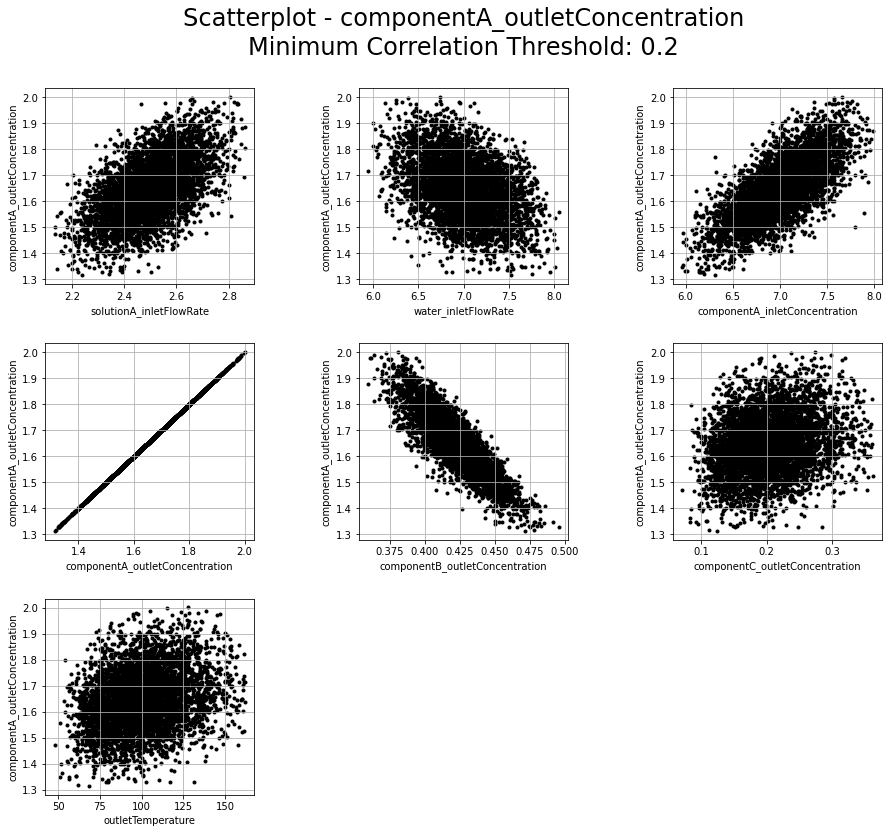

In [33]:
thres = 0.2
elec_var = 'componentA_outletConcentration'
scatter_analysis(data_t, elec_var, thres)

Com base nos gráficos acima, podemos ter as seguintes conclusões a respeito da concentração de saída do componente A:

- aumentando-se tanto a vazão de entrada do componente A como a concentração de entrada do componente A, espera-se um aumento aproximadamente proporcional da concentração de saída (direto do balanço de massa)
- aumentando-se a vazão de entrada de água, espera-se uma diluição e, portanto, a diminuição da concentração de saída
- o aumento da concentração de saída correlaciona-se com a diminuição da concentração de componente B (há maior consumo do reagente limitante). Consequentemente, espera-se o aumento da concentração do componente C, da temperatura de saída e da conversão

### **2.2. Concentração de Saída do Componente B**

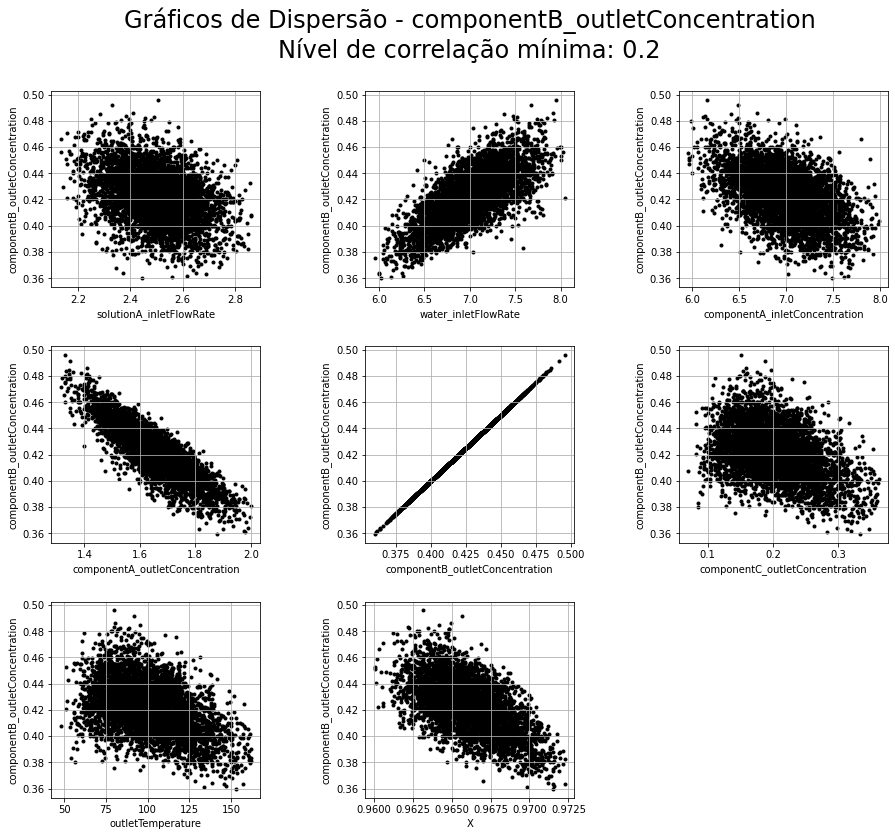

In [30]:
thres = 0.2
elec_var = 'componentB_outletConcentration'
scatter_analysis(data_t, elec_var, thres)

Os gráficos de dispersão apresentam as seguintes conclusões:

- O aumento da vazão de entrada do componente A e de sua concentração promove a diminuição da concentração de saída do componente B, visto que essas variáveis promovem o aumento da taxa de reação, aumentando o consumo desse componente (que é o limitante)
- o aumento da vazão de entrada de água promove o aumento da concentração de componente B na saída, visto que promove a diluição das concentrações no interior do reator, e assim o abaixamento da taxa de reação
- o aumento da concentração de saída do componente B está relacionado com a dimiuição da concentração de componente C, da temperatura de saída e da conversão, visto que se mais componente B está saindo do reator, então significa que a reação está ocorrendo com menor grau de avanço

### **2.3. Concentração de Saída do Componente C**

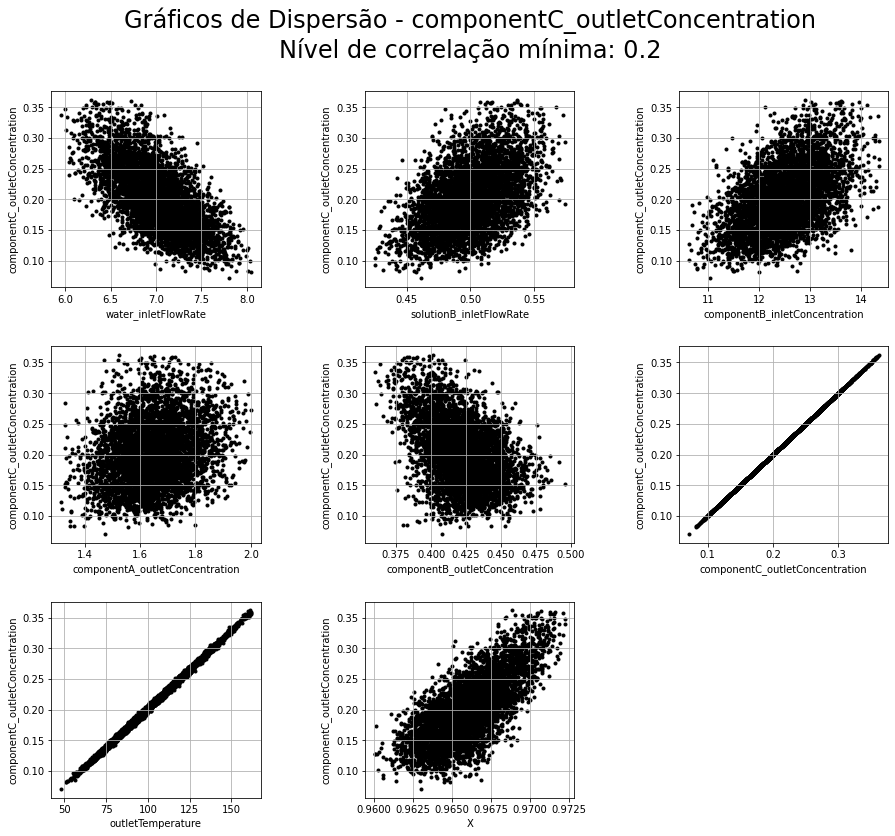

In [31]:
thres = 0.2
elec_var = 'componentC_outletConcentration'
scatter_analysis(data_t, elec_var, thres)

Os gráficos de dispersão mostram as seguintes conclusões para a concentração de saída do componente C
- o aumento da vazão de água na entrada promove a redução da concentração de componente C na saída, visto que a diluição dos componentes promove a redução da taxa de reação
- tanto o aumento da vazão de entrada do componente B quanto sua concentração promovem o aumento da concentração de saída do componente C, visto que ambas as variáveis promovem o aumento da taxa de reação (componente B é o limitante)
- o aumento da concentração do componente C está correlacionado com o aumento da concentração do componente A na saída, visto que se mais componente A é adicionado no reator, então maior será a taxa de reação e portanto, mais produto será produzido.
- também se pode observar uma correlação negativa com a concentração de componente B, visto que se mais componente C está saindo do reator, mais componente B será consumido e, portanto, menor será a concentração de B na saída
- pode-se notar que a concentração de componente C está bem correlacionada com a temperatura de saída, o que apresentar uma oportunidade de controle de processo, visto que, geralmente, a medida da temperatura é mais fácil que a medida da concentração.
- finalmente, o aumento da concentração está relacionado com o aumento da conversão, visto que uma maior conversão significa maior produção de componente C pela reação química. 

### **2.4. Temperatura de Saída**

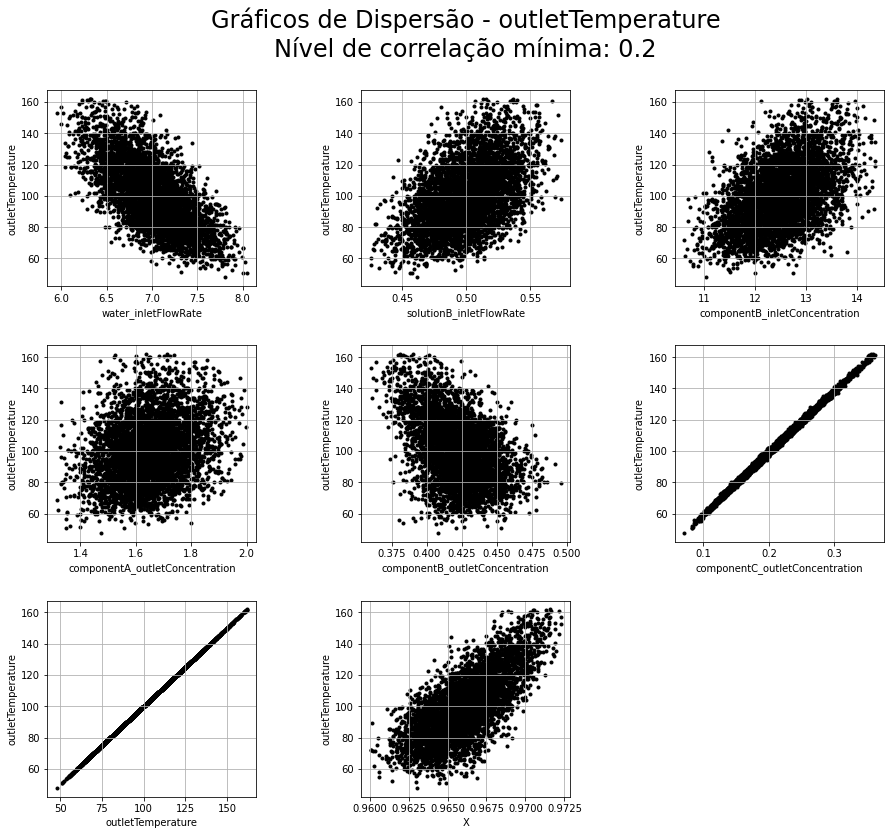

In [32]:
thres = 0.2
elec_var = 'outletTemperature'
scatter_analysis(data_t, elec_var, thres)

As conclusões obtidas para a temperatura de saída seguem a mesma linha de raciocínio das obtidos devido principalmente ao alto grau de correlação existente entre essas duas variáveis.

### **2.5. Conversão**

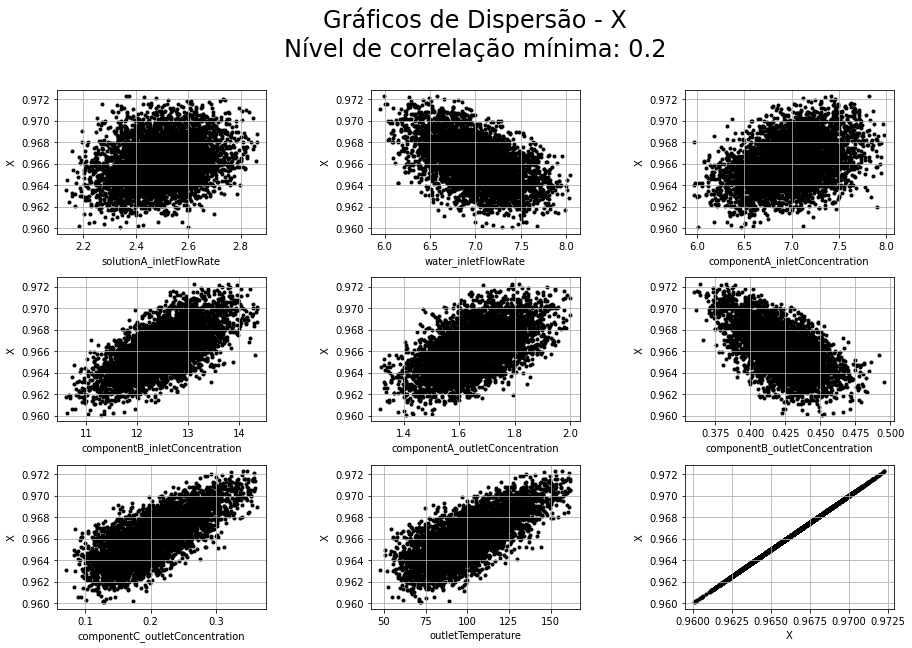

In [33]:
thres = 0.2
elec_var = 'X'
scatter_analysis(data_t, elec_var, thres)

As conclusões que podem ser tiradas para o caso da correlação da conversão com as outras variáveis são análogas àquelas tiradas sobre a relação dessas variáveis com a concentração do componente B na saída.

## **3. Análise de Controle Estatístico de Processo**

Esta seção é dedicada para a análise do processo do ponto de vista do controle estatístico de processo.

O controle estatístico de processo é uma ferramenta utilizada para entender se um processo está sob controle estatístico. Diz-se que um processo está sob controle quando as variações observadas se encontram dentro dos limites estatísticos, que representam a variação máxima considerada como *natural*.

Caso as variações sejam maiores que esses limites, diz-se que os processos estão sob influência de causas *especiais*, ou seja, existe uma influência externa que está provocando a anomalia no processo.

Nesse processo, vamos simular que a aquisição de dados relacionados à qualidade do produto seja realizada em laboratório, de 15 em 15 minutos. Ou seja, para cada hora de produção, 4 amostras são coletadas e analisadas.

### **3.1. Concentração de Saída - Componente A**

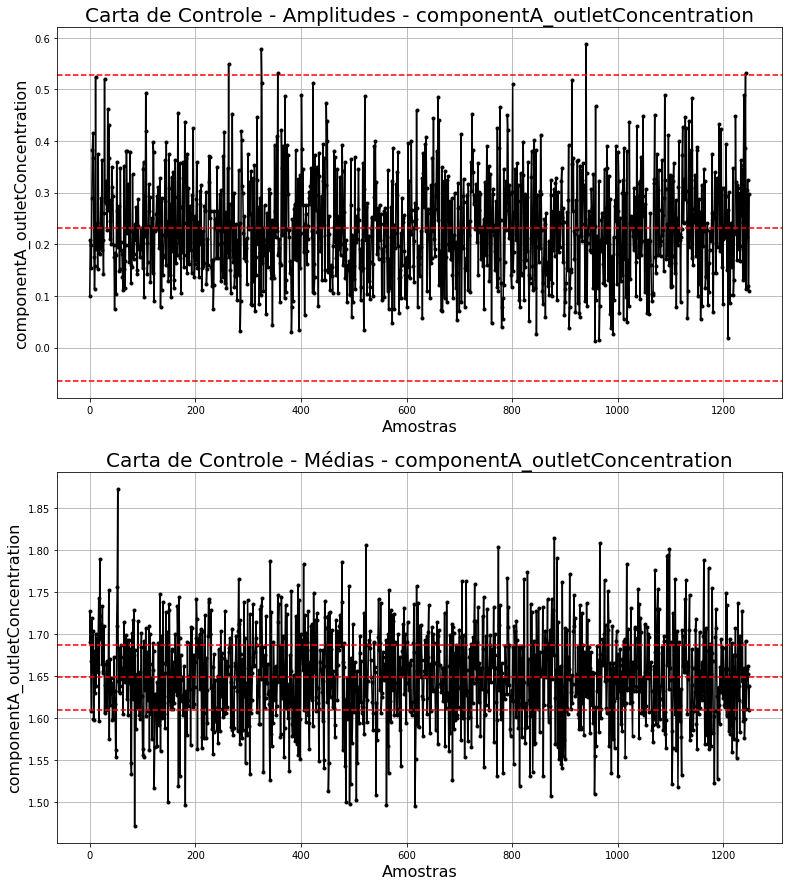

In [34]:
var_name = 'componentA_outletConcentration'

results_A_out = control_chart(data_t, var_name, n = 4)

Como se pode observar, há muitos pontos referentes à concentração de saída da componente A que se encontram fora dos limites estatísticos de controle.

Isso mostra que o processo se encontra instável, sujeito a muitas causas especiais que estão promovendo variações acima dos limites aceitáveis para esse processo.

### **3.2. Concentração de Saída - Componente B**

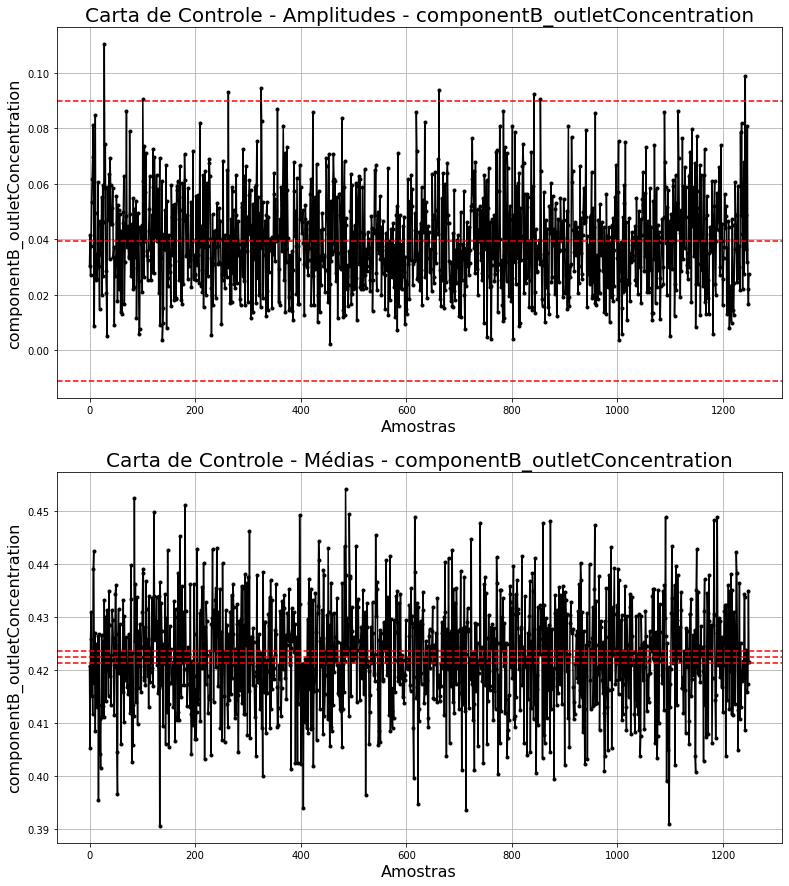

In [35]:
var_name = 'componentB_outletConcentration'

results_B_out = control_chart(data_t, var_name, n = 4)


### **3.3. Concentração de Saída - Componente C**

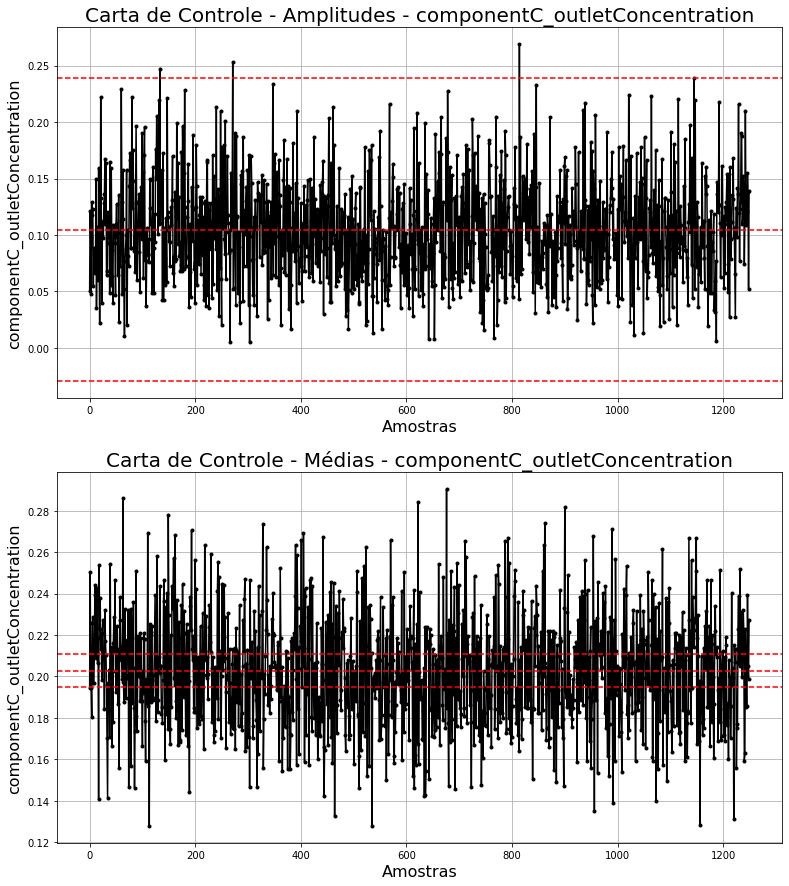

In [36]:
var_name = 'componentC_outletConcentration'

results_C_out = control_chart(data_t, var_name, n = 4)

## **4. Estratégia de Modelagem e Pré-processamento**

Verifica-se que todas as variáveis de saída importantes, que são as concentrações de saída de A, B e C mostram um processo totalmente instável, pois existem muitos pontos fora dos limites de controle estatístico de processo.

Nesse caso, não estudaremos a temperatura de saída, devido à sua alta correlação com a concentração de saída do componente C. Como serão três variáveis de saída, três modelos de clusterização serão classificados, no intuito de entender os padrões de variáveis de entrada que promovem a instabilidade no processo.

### **4.1. Criação de Novas Variáveis**

Nessa etapa será criada uma variável indicadora do controle estatístico de processo, seguindo a seguinte a lógica:

- 0 - para dados dentro dos limites de controle estatístico
- 1 - para dados acima do limite superior ou abaixo do limite inferior de controle estatístico

In [37]:
# criação de novas variáveis
def new_feat(data, keys_values, col_name):

  # extração dos valores do dicionários
  LIC_X = keys_values['LIC_X']
  LSC_X = keys_values['LSC_X']

  # criação de nova variável indicativa da situação de controle estatístico
  data['CONTROL'] = int(0)
  data.loc[data[col_name] > LSC_X,'CONTROL'] = int(1)
  data.loc[data[col_name] < LIC_X,'CONTROL'] = int(1)

  # reiniciando índices
  data = data.reset_index()
  data.drop(['index'], axis = 1, inplace = True)

  return data

In [38]:
# tratamento de dados para concentração de A na saída
col_name = 'componentA_outletConcentration'
to_drop = ['componentB_outletConcentration', 'componentC_outletConcentration', 
           'outletTemperature']
dataA = data_t.copy()
dataA.drop(to_drop, axis = 1, inplace = True)

dataA = new_feat(dataA, results_A_out, col_name)
dataA['CONTROL'].value_counts()

1    3575
0    1285
Name: CONTROL, dtype: int64

In [39]:
# tratamento de dados para concentração de B na saída
col_name = 'componentB_outletConcentration'
to_drop = ['componentA_outletConcentration', 'componentC_outletConcentration','outletTemperature']
dataB = data_t.copy()
dataB.drop(to_drop, axis = 1, inplace = True)

dataB = new_feat(dataB, results_B_out, col_name)
dataB['CONTROL'].value_counts()

1    4623
0     237
Name: CONTROL, dtype: int64

In [40]:
# tratamento de dados para concentração de C na saída
col_name = 'componentC_outletConcentration'
to_drop = ['componentA_outletConcentration', 'componentB_outletConcentration', 'outletTemperature']
dataC = data_t.copy()
dataC.drop(to_drop, axis = 1, inplace = True)

dataC = new_feat(dataC, results_C_out, col_name)
dataC['CONTROL'].value_counts()

1    4303
0     557
Name: CONTROL, dtype: int64

### **4.2. Separação do conjunto de treinamento e teste**

A amostragem para o conjunto de treinamento e teste será realizada por meio de amostragem estratificada, para preservar o balanceamento entre as classes em ambos os conjuntos.

In [41]:
# amostragem estratificada para preservar o balanceamento entre classes no conjunto de treinamento e teste
def dataset_split(data, split_var, to_drop_list):

  # gerando split estratificado
  split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = RANDOM_SEED)

  # aplicando o split
  for train_index, test_index in split.split(data, data[split_var]):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]

  # separando em preditores e target
  y_train = train_set[split_var]
  x_train = train_set.drop(to_drop_list + [split_var], axis = 1)

  y_test = test_set[split_var]
  x_test = test_set.drop(to_drop_list + [split_var], axis = 1)

  return x_train, x_test, y_train, y_test  

In [42]:
x_trainA, x_testA, y_trainA, y_testA = dataset_split(dataA, 'CONTROL', ['componentA_outletConcentration', 'X'])
x_trainB, x_testB, y_trainB, y_testB = dataset_split(dataB, 'CONTROL', ['componentB_outletConcentration', 'X'])
x_trainC, x_testC, y_trainC, y_testC = dataset_split(dataC, 'CONTROL', ['componentC_outletConcentration', 'X'])

### **4.3. Aplicação de Escalonamento de Variáveis**

#### 4.2.1. Concentração de Saída do Componente A

In [43]:
scalerA = StandardScaler()

# treinamento do scaler
scalerA = scalerA.fit(x_trainA)

x_trainA = pd.DataFrame(scalerA.transform(x_trainA), index = x_trainA.index, columns = x_trainA.columns)
x_testA = pd.DataFrame(scalerA.transform(x_testA), index = x_testA.index, columns = x_testA.columns)

#### 4.2.2. Concentração de Saída do Componente B

In [44]:
scalerB = StandardScaler()

# treinamento do scaler
scalerB = scalerB.fit(x_trainB)

x_trainB = pd.DataFrame(scalerB.transform(x_trainB), index = x_trainB.index, columns = x_trainB.columns)
x_testB = pd.DataFrame(scalerB.transform(x_testB), index = x_testB.index, columns = x_testB.columns)

#### 4.2.3. Concentração de Saída do Componente C

In [45]:
scalerC = StandardScaler()

# treinamento do scaler
scalerC = scalerC.fit(x_trainC)

x_trainC = pd.DataFrame(scalerC.transform(x_trainC), index = x_trainC.index, columns = x_trainC.columns)
x_testC = pd.DataFrame(scalerC.transform(x_testC), index = x_testC.index, columns = x_testC.columns)

### 4.4. Dimensionality Reduction Techniques

Existem muitas variáveis de entrada que podem apresentar muitas combinações
